In [185]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import re
import warnings

In [186]:
warnings.filterwarnings('ignore')

In [187]:
# recuperer les données et retirer les colonnes inutiles
fake_news = pd.read_csv('dataset/Fake.csv', usecols=['text'])
true_news = pd.read_csv('dataset/True.csv', usecols=['text'])

In [188]:
# Fonction de nettoyage du texte
def clean_text(text):
    text = re.sub(r'\W', ' ', text)  # Supprimer les caractÃ¨res spÃ©ciaux
    text = re.sub(r'\s+', ' ', text)  # Supprimer les espaces multiples
    text = re.sub(r'https?://\S+|www.\S+', '', text)  # Supprimer les liens
    text = text.lower()  # Convertir en minuscules
    text = text.strip()  # Supprimer les espaces en dÃ©but et fin de texte
    text = re.sub(r'\d+', '', text)  # Supprimer les chiffres
    text = re.sub(r'<.*?>', '', text)  # Supprimer les balises HTML
    return text

In [189]:
# Appliquer la fonction de nettoyage
fake_news['text'] = fake_news['text'].apply(clean_text)
true_news['text'] = true_news['text'].apply(clean_text)

In [190]:
# Ajouter une colonne 'label' pour indiquer les fake news (1) et les vraies news (0)
fake_news['label'] = 1
true_news['label'] = 0

In [191]:
# Combiner les deux DataFrames
data = pd.concat([fake_news, true_news], ignore_index=True)

In [192]:
# Vérifier les valeurs manquantes dans le DataFrame
missing_values = data.isnull().sum()

In [193]:
# Afficher les colonnes avec des valeurs manquantes
print("Valeurs manquantes par colonne :")
print(missing_values)

Valeurs manquantes par colonne :
text     0
label    0
dtype: int64


In [194]:
def calculate_average_word_count(data):
    """
    Calcule le nombre moyen de mots dans les textes du DataFrame.

    Args:
    data (pd.DataFrame): DataFrame contenant une colonne 'text'.

    Returns:
    float: Nombre moyen de mots par texte.
    """
    data['word_count'] = data['text'].apply(lambda x: len(x.split()))
    return data['word_count'].mean()

In [195]:
def plot_label_distribution(data):
    """
    Affiche la rÃ©partition des labels (fake news et true news) dans le DataFrame.

    Args:
    data (pd.DataFrame): DataFrame contenant une colonne 'label'.
    """
    sns.countplot(x='label', data=data)
    plt.title('Répartition des Fake News et True News')
    plt.xlabel('Label')
    plt.ylabel('Nombre d\'articles')
    plt.xticks(ticks=[0, 1], labels=['True News', 'Fake News'])
    plt.show()

In [196]:
print(f'Fake News Average Word Count: {calculate_average_word_count(fake_news)}')
print(f'True News Average Word Count: {calculate_average_word_count(true_news)}')

Fake News Average Word Count: 430.760487202419
True News Average Word Count: 388.1101461455853


In [197]:
# Extraire les articles fake
fake_texts = data[data['label'] == 1]['text']

In [198]:
# Vectoriser les mots avec CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=20)
word_counts = vectorizer.fit_transform(fake_texts)

In [199]:
# Afficher les mots les plus fréquents
words = vectorizer.get_feature_names_out()
counts = word_counts.sum(axis=0).A1
word_freq = pd.DataFrame({'Word': words, 'Frequency': counts}).sort_values(by='Frequency', ascending=False)
print(word_freq)

         Word  Frequency
17      trump      79805
14       said      33763
13  president      27804
12     people      26589
6        just      20570
2     clinton      19211
11      obama      18836
7        like      18116
3      donald      17780
10       news      14651
9         new      14413
4     hillary      14171
16       time      13854
15      state      13470
19      white      13195
18    twitter      11790
8       media      11704
1    american      11323
0     america      11190
5       house      11115


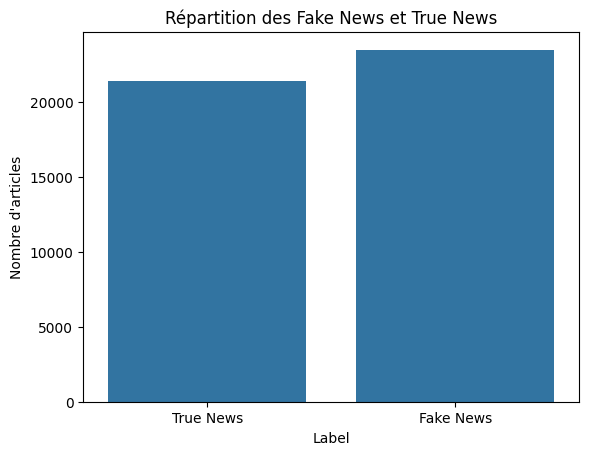

In [200]:
# Afficher la répartition des labels
plot_label_distribution(data)

In [201]:
# Séparer les caractéristiques et les labels
X = data['text']
y = data['label']

In [202]:
# Diviser les données en ensembles d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [203]:
# Convertir le texte en caractéristiques numériques
# TF-IDF amélioré avec n-grams
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),  # Utiliser les unigrammes et bigrammes
    max_features=5000,   # Limiter le nombre de caractéristiques
    min_df=2,           # Ignorer les termes rares
    max_df=0.95         # Ignorer les termes trop fréquents
)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

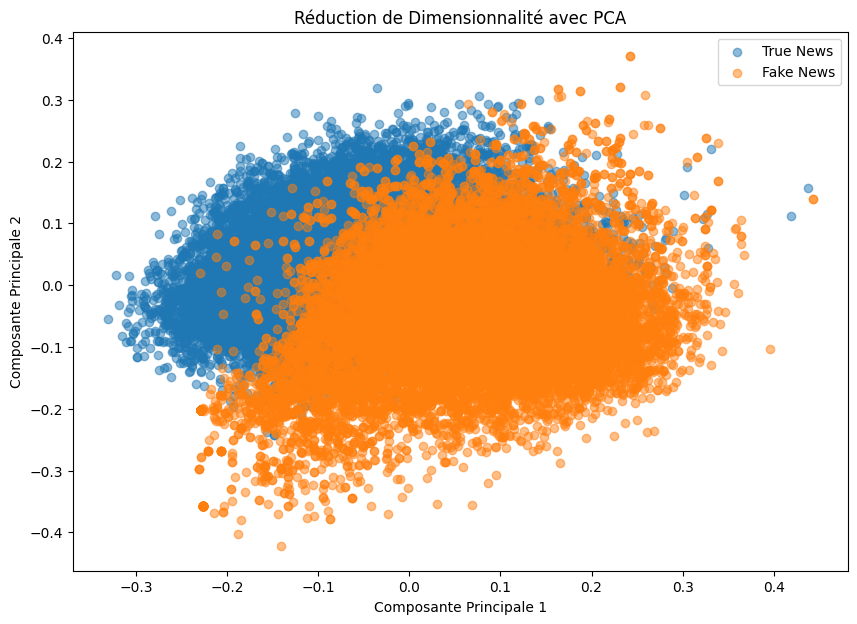

In [204]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Réduction de dimensionnalité avec PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_tfidf.toarray())

# Visualisation
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[y_train == 0, 0], X_pca[y_train == 0, 1], label='True News', alpha=0.5)
plt.scatter(X_pca[y_train == 1, 0], X_pca[y_train == 1, 1], label='Fake News', alpha=0.5)
plt.legend()
plt.title('Réduction de Dimensionnalité avec PCA')
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.show()

In [205]:
import numpy as np

# Calcul de la moyenne des vecteurs pour chaque classe
mean_class_0 = np.asarray(X_train_tfidf[y_train == 0].mean(axis=0))
mean_class_1 = np.asarray(X_train_tfidf[y_train == 1].mean(axis=0))

# Calcul de la distance euclidienne entre les classes
from sklearn.metrics.pairwise import euclidean_distances

distance = euclidean_distances(mean_class_0, mean_class_1)
print(f'Distance euclidienne entre les classes: {distance[0][0]}')

Distance euclidienne entre les classes: 0.18253214960876848


In [206]:
# Créer et entrainer le modèle de régression logistique
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

LogisticRegression()

In [207]:
# Prédire sur l'ensemble de test
y_pred = model.predict(X_test_tfidf)

In [208]:
# Calculer les métriques
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

In [209]:
# Afficher les résultats
print(f'Logistic Regression Accuracy: {accuracy}')
print(f'Logistic Regression Precision: {precision}')
print(f'Logistic Regression Recall: {recall}')
print(f'Logistic Regression F1-Score: {f1}')
print(f'Logistic Regression Confusion Matrix:\n{cm}')
print(f'Logistic Regression AUC-ROC: {auc}')

Logistic Regression Accuracy: 0.989532293986637
Logistic Regression Precision: 0.9913153992798136
Logistic Regression Recall: 0.9888020283118529
Logistic Regression F1-Score: 0.9900571186799239
Logistic Regression Confusion Matrix:
[[4206   41]
 [  53 4680]]
Logistic Regression AUC-ROC: 0.9895740774947538


In [210]:
# Créer et entrainer le modèle de forêt aléatoire
model = RandomForestClassifier(
    n_estimators=100,  # Nombre d'arbres
    max_depth=10,      # Profondeur maximale de chaque arbre
    random_state=42
)
model.fit(X_train_tfidf, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

In [211]:
# Prédire sur l'ensemble de test
y_pred = model.predict(X_test_tfidf)

In [212]:
# Calculer les métriques
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

In [213]:
# Afficher les résultats
print(f'Random Forest Accuracy: {accuracy}')
print(f'Random Forest Precision: {precision}')
print(f'Random Forest Recall: {recall}')
print(f'Random Forest F1-Score: {f1}')
print(f'Random Forest Confusion Matrix:\n{cm}')
print(f'Random Forest AUC-ROC: {auc}')

Random Forest Accuracy: 0.9917594654788419
Random Forest Precision: 0.9951115834218917
Random Forest Recall: 0.989224593281217
Random Forest F1-Score: 0.9921593557957195
Random Forest Confusion Matrix:
[[4224   23]
 [  51 4682]]
Random Forest AUC-ROC: 0.9919045029038532


In [214]:
# Créer et entrainer le modèle d'arbre de décision
model = DecisionTreeClassifier()
model.fit(X_train_tfidf, y_train)
import joblib

# Sauvegarder le modèle entraîné
joblib.dump(model, 'c:/Users/ilyes/Documents/fac/Fouille/Projet/models/decision_tree_model.joblib')


['c:/Users/ilyes/Documents/fac/Fouille/Projet/models/decision_tree_model.joblib']

In [156]:
# Prédire sur l'ensemble de test
y_pred = model.predict(X_test_tfidf)

In [158]:
# Afficher les résultats
print(f'Decision Tree Accuracy: {accuracy}')
print(f'Decision Tree Precision: {precision}')
print(f'Decision Tree Recall: {recall}')
print(f'Decision Tree F1-Score: {f1}')
print(f'Decision Tree Confusion Matrix:\n{cm}')
print(f'Decision Tree AUC-ROC: {auc}')

Decision Tree Accuracy: 0.9968819599109131
Decision Tree Precision: 0.9970420452144517
Decision Tree Recall: 0.9970420452144517
Decision Tree F1-Score: 0.9970420452144517
Decision Tree Confusion Matrix:
[[4233   14]
 [  14 4719]]
Decision Tree AUC-ROC: 0.9968728003326791


In [175]:
# Créer et entrainer le modèle SVM linéaire
model = SVC()
model.fit(X_train_tfidf, y_train)

SVC()

In [160]:
# Prédire sur l'ensemble de test
y_pred = model.predict(X_test_tfidf)

In [161]:
# Calculer les métriques
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

In [162]:
# Afficher les résultats
print(f'SVM Accuracy: {accuracy}')
print(f'SVM Precision: {precision}')
print(f'SVM Recall: {recall}')
print(f'SVM F1-Score: {f1}')
print(f'SVM Confusion Matrix:\n{cm}')
print(f'SVM AUC-ROC: {auc}')

SVM Accuracy: 0.9955456570155902
SVM Precision: 0.9955649419218585
SVM Recall: 0.9959856327910416
SVM F1-Score: 0.9957752429235319
SVM Confusion Matrix:
[[4226   21]
 [  19 4714]]
SVM AUC-ROC: 0.9955204829837007


In [163]:
# Créer et entrainer le modèle naif de Bayes
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

MultinomialNB()

In [164]:
# Prédire sur l'ensemble de test
y_pred = model.predict(X_test_tfidf)

In [165]:
# Calculer les métriques
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

In [166]:
# Afficher les résultats
print(f'Naive Bayes Accuracy: {accuracy}')
print(f'Naive Bayes Precision: {precision}')
print(f'Naive Bayes Recall: {recall}')
print(f'Naive Bayes F1-Score: {f1}')
print(f'Naive Bayes Confusion Matrix:\n{cm}')
print(f'Naive Bayes AUC-ROC: {auc}')

Naive Bayes Accuracy: 0.9444320712694878
Naive Bayes Precision: 0.9481371718882303
Naive Bayes Recall: 0.946334248890767
Naive Bayes F1-Score: 0.9472348524902189
Naive Bayes Confusion Matrix:
[[4002  245]
 [ 254 4479]]
Naive Bayes AUC-ROC: 0.9443232346408156


                 Model  Accuracy  Precision  Recall  F1-Score     AUC
0  Logistic Regression    0.9846     0.9867  0.9842    0.9854  0.9847
1        Random Forest    0.9909     0.9920  0.9907    0.9913  0.9909
2        Decision Tree    0.9950     0.9960  0.9945    0.9952  0.9950
3                  SVM    0.9930     0.9953  0.9913    0.9933  0.9931
4          Naive Bayes    0.9321     0.9289  0.9434    0.9361  0.9314


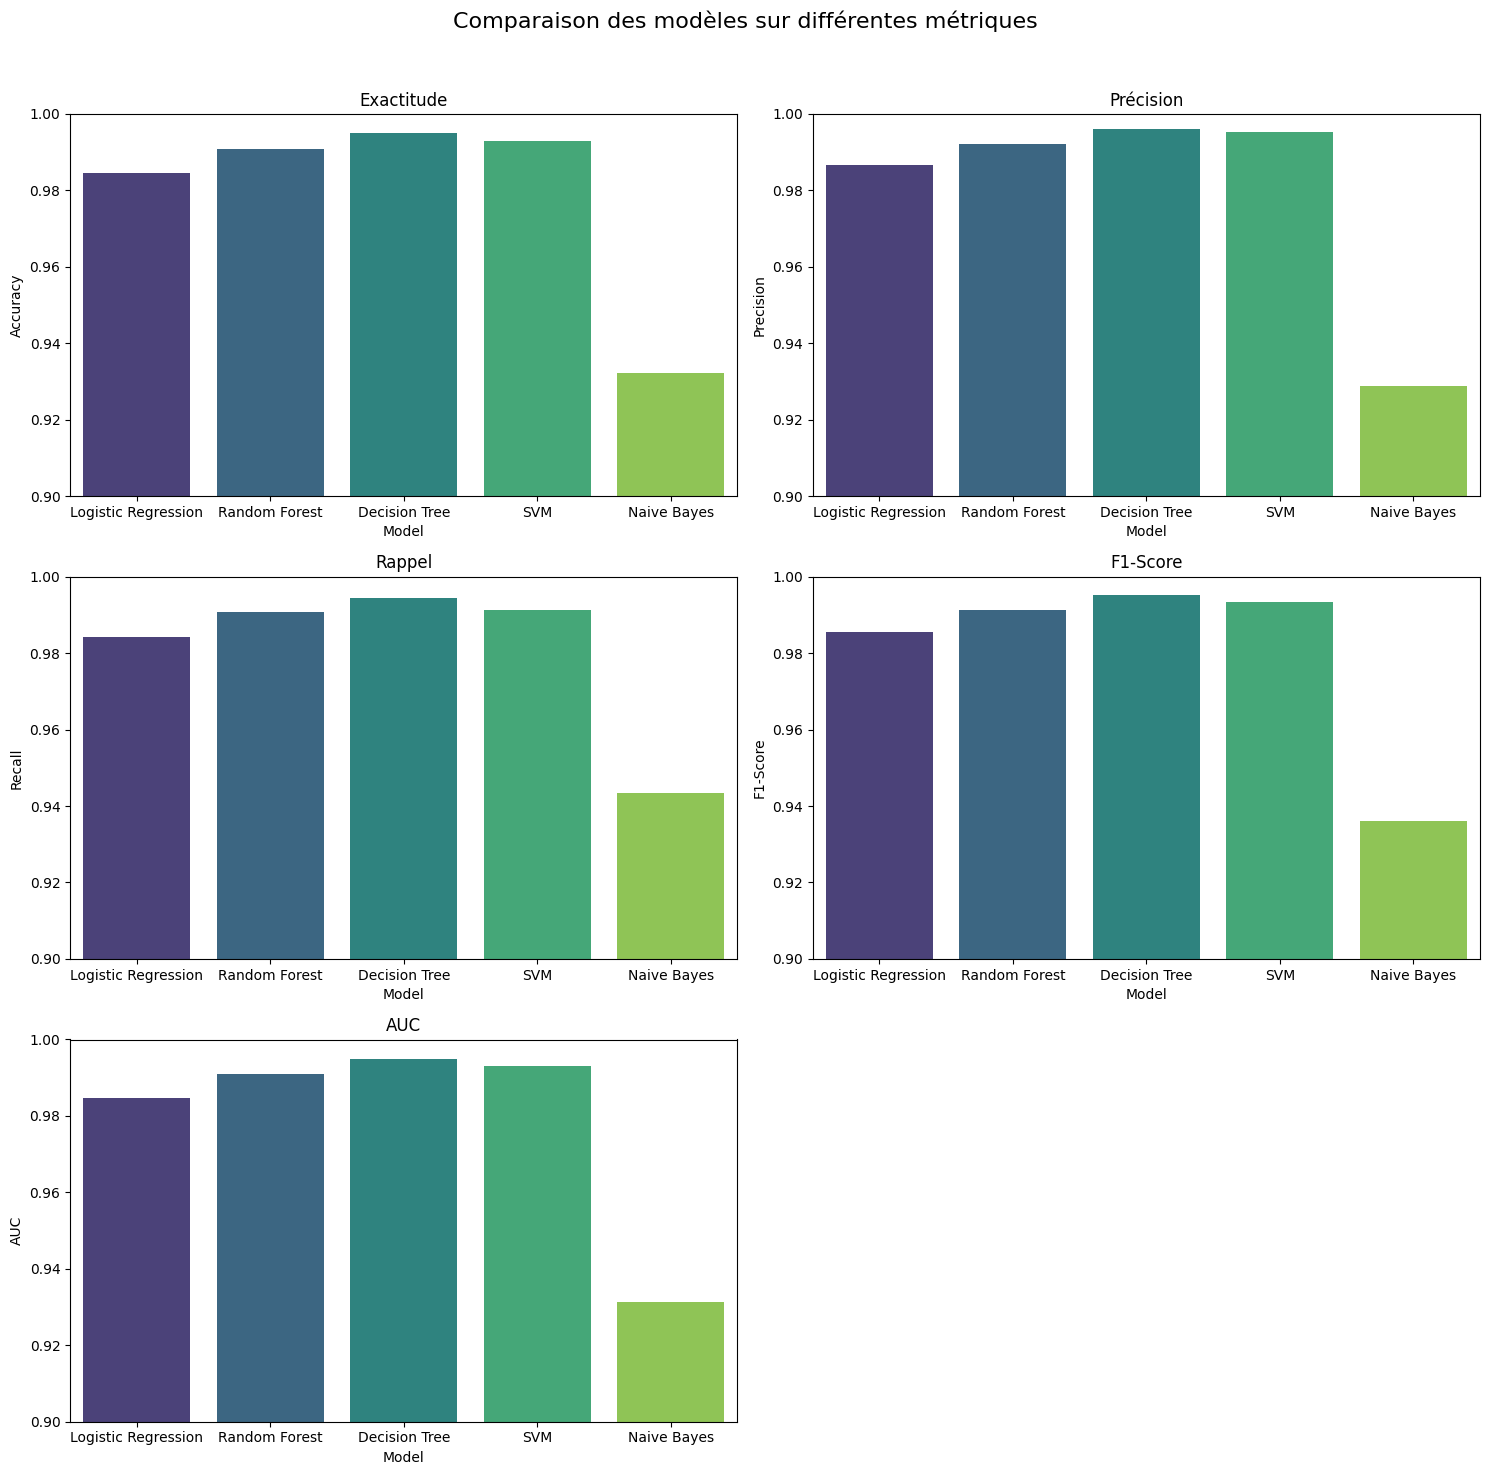

In [168]:

# Résultats des modèles
results = {
    'Model': ['Logistic Regression', 'Random Forest', 'Decision Tree', 'SVM', 'Naive Bayes'],
    'Accuracy': [0.9846, 0.9909, 0.9950, 0.9930, 0.9321],
    'Precision': [0.9867, 0.9920, 0.9960, 0.9953, 0.9289],
    'Recall': [0.9842, 0.9907, 0.9945, 0.9913, 0.9434],
    'F1-Score': [0.9854, 0.9913, 0.9952, 0.9933, 0.9361],
    'AUC': [0.9847, 0.9909, 0.9950, 0.9931, 0.9314]
}

# Convertir les résultats en DataFrame
performance_df = pd.DataFrame(results)

# Afficher les résultats
print(performance_df)

# Créer des sous-graphiques pour chaque métrique
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.suptitle('Comparaison des modèles sur différentes métriques', fontsize=16)

# Tracer les performances pour chaque métrique
sns.barplot(ax=axes[0, 0], x='Model', y='Accuracy', data=performance_df, palette='viridis')
axes[0, 0].set_ylim(0.9, 1.0)
axes[0, 0].set_title('Exactitude')

sns.barplot(ax=axes[0, 1], x='Model', y='Precision', data=performance_df, palette='viridis')
axes[0, 1].set_ylim(0.9, 1.0)
axes[0, 1].set_title('Précision')

sns.barplot(ax=axes[1, 0], x='Model', y='Recall', data=performance_df, palette='viridis')
axes[1, 0].set_ylim(0.9, 1.0)
axes[1, 0].set_title('Rappel')

sns.barplot(ax=axes[1, 1], x='Model', y='F1-Score', data=performance_df, palette='viridis')
axes[1, 1].set_ylim(0.9, 1.0)
axes[1, 1].set_title('F1-Score')

sns.barplot(ax=axes[2, 0], x='Model', y='AUC', data=performance_df, palette='viridis')
axes[2, 0].set_ylim(0.9, 1.0)
axes[2, 0].set_title('AUC')

# Supprimer le dernier sous-graphe vide
fig.delaxes(axes[2, 1])

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()